In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Определение преобразований
W, H = 64, 64
train_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((H, W)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.4, contrast=1.5, saturation=1.2, hue=0.5),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((H, W)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.ToPILImage(),
    transforms.ColorJitter(contrast=1.5),
])

# Загрузка данных
data_dir = r'F:\grozny\beeline\train_borders\recog'
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Разделение данных на тренировочные и тестовые
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Применение различных преобразований к тестовому набору данных
test_dataset.dataset.transform = test_transforms

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Определение модели
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)
    
    def forward(self, x):
        x = self.batchNorm1(self.pool(F.relu(self.conv1(x))))
        x = self.batchNorm2(self.pool(F.relu(self.conv2(x))))
        x = self.batchNorm3(self.pool(F.relu(self.conv3(x))))
        x = x.view(-1, 64 * 8 * 8)  # Изменяем размер тензора для Fully Connected слоя
        x = self.drop(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Инициализация модели, функции потерь и оптимизатора
model = SimpleCNN().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция для вычисления точности
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

# Обучение модели
num_epochs = 60
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    correct = 0
    total = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()  # Обнуляем градиенты
        
        outputs = model(inputs)  # Прямой проход
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        loss = criterion(outputs, labels)  # Вычисление ошибки
        correct += (predicted == labels).sum().item()
        loss.backward()  # Обратный проход
        optimizer.step()  # Обновление параметров
        
        running_loss += loss.item()
    train_acc = correct / total
    
    correct = 0
    total = 0
    running_loss = 0.0
    for inputs, labels in test_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()  # Обнуляем градиенты
        
        outputs = model(inputs)  # Прямой проход
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        loss = criterion(outputs, labels)  # Вычисление ошибки
        correct += (predicted == labels).sum().item()        
        running_loss += loss.item()
    
    
    test_acc = correct / total
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_acc}, Test Accuracy: {test_acc}')

# Сохранение весов модели
torch.save(model, 'model_weights_loc.pth')

C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/60], Loss: 0.21308114713635937, Train Accuracy: 0.6853448275862069, Test Accuracy: 0.7456896551724138
Epoch [2/60], Loss: 0.15597342725457816, Train Accuracy: 0.771551724137931, Test Accuracy: 0.75
Epoch [3/60], Loss: 0.1548354944278454, Train Accuracy: 0.7984913793103449, Test Accuracy: 0.7801724137931034
Epoch [4/60], Loss: 0.14635000968801565, Train Accuracy: 0.8157327586206896, Test Accuracy: 0.7327586206896551
Epoch [5/60], Loss: 0.15018886122210273, Train Accuracy: 0.8394396551724138, Test Accuracy: 0.7931034482758621
Epoch [6/60], Loss: 0.13141045179860344, Train Accuracy: 0.8685344827586207, Test Accuracy: 0.8189655172413793
Epoch [7/60], Loss: 0.1251060823942053, Train Accuracy: 0.8663793103448276, Test Accuracy: 0.8103448275862069
Epoch [8/60], Loss: 0.1615719086137311, Train Accuracy: 0.8588362068965517, Test Accuracy: 0.7931034482758621
Epoch [9/60], Loss: 0.1599075403706781, Train Accuracy: 0.8706896551724138, Test Accuracy: 0.7974137931034483
Epoch [10/60], Loss:

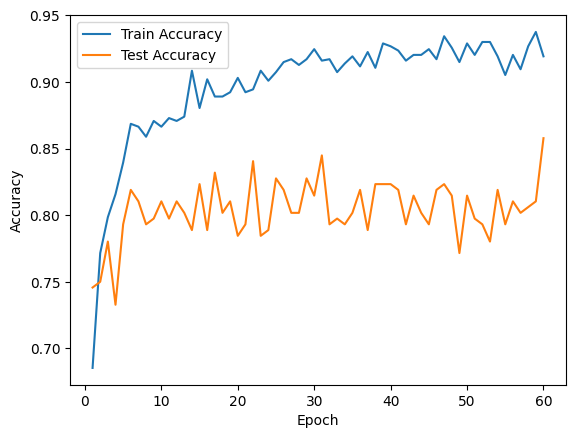

In [2]:
# Визуализация точности
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

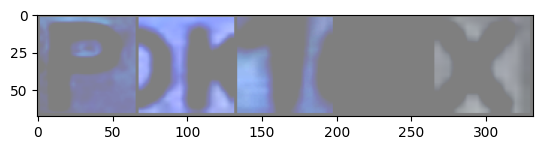

GroundTruth:  1 2 0 2 1
Predicted:  1 2 0 1 1


In [3]:
# Отображение предсказаний на тестовом наборе
model.eval()
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)

# Функция для отображения изображений
def imshow(img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Отображение первых 5 тестовых изображений и их предсказаний
imshow(utils.make_grid(images[:5]))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(5)))
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(5)))